In [1]:
import torch
import torchaudio.functional as F
import torchaudio.transforms as T

C:\Users\tomgr\anaconda3\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\tomgr\anaconda3\lib\site-packages\torchaudio\backend\utils.py:89: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [2]:
torch.cuda.is_available()

True

In [3]:
import numpy as np

In [4]:
import scipy.signal as ss
import random

In [5]:
import socketserver
import socket
import struct
import json

import numpy as np


class IPCError(Exception):
    pass

class UnknownMessageClass(IPCError):
    pass

class InvalidSerialization(IPCError):
    pass

class ConnectionClosed(IPCError):
    pass


def _read_objects(sock):
    header = sock.recv(4)
    if len(header) == 0:
        raise ConnectionClosed()
    size = struct.unpack('!i', header)[0]
    data = sock.recv(size - 4)
    if len(data) == 0:
        raise ConnectionClosed()
    return Message.deserialize(json.loads(data))


def _write_objects(sock, objects):
    data = json.dumps([o.serialize() for o in objects])
    sock.sendall(struct.pack('!i', len(data) + 4))
    sock.sendall(data)

def _recursive_subclasses(cls):
    classmap = {}
    for subcls in cls.__subclasses__():
        classmap[subcls.__name__] = subcls
        classmap.update(_recursive_subclasses(subcls))
    return classmap


class Message(object):
    @classmethod
    def deserialize(cls, objects):
        classmap = _recursive_subclasses(cls)
        serialized = []
        for obj in objects:
            if isinstance(obj, Message):
                serialized.append(obj)
            else:
                try:
                    serialized.append(classmap[obj['class']](*obj['args'], **obj['kwargs']))
                except KeyError as e:
                    raise UnknownMessageClass(e)
                except TypeError as e:
                    raise InvalidSerialization(e)
        return serialized

    def serialize(self):
        args, kwargs = self._get_args()
        return {'class': type(self).__name__, 'args': args, 'kwargs': kwargs}

    def _get_args(self):
        return [], {}

    def __repr__(self):
        r = self.serialize()
        args = ', '.join([repr(arg) for arg in r['args']])
        kwargs = ''.join([', {}={}'.format(k, repr(v)) for k, v in r['kwargs'].items()])
        name = r['class']
        return '{}({}{})'.format(name, args, kwargs)


class Client(object):
    def __init__(self, server_address):
        self.addr = server_address
        if isinstance(self.addr, str):
            address_family = socket.AF_UNIX
        else:
            address_family = socket.AF_INET
        self.sock = socket.socket(address_family, socket.SOCK_STREAM)

    def connect(self):
        self.sock.connect(self.addr)

    def close(self):
        self.sock.close()

    def __enter__(self):
        self.connect()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.close()

    def send(self, objects):
        _write_objects(self.sock, objects)
        return _read_objects(self.sock)

    def recv(self, data):
        print("ooh got data")


class Server(socketserver.ThreadingTCPServer):
    def __init__(self, server_address, callback, bind_and_activate=True):
        if not callable(callback):
            callback = lambda x: []

        class IPCHandler(socketserver.BaseRequestHandler):
            def handle(self):
                while True:
                    try:
                        results = _read_objects(self.request)
                    except ConnectionClosed as e:
                        return
                    _write_objects(self.request, callback(results))

        if isinstance(server_address, str):
            self.address_family = socket.AF_UNIX
        else:
            self.address_family = socket.AF_INET

        socketserver.TCPServer.__init__(self, server_address, IPCHandler, bind_and_activate)

In [6]:
class Event(Message):
    def __init__(self, event_type, **properties):
        self.type = event_type
        self.properties = properties

    def _get_args(self):
        return [self.type], self.properties


class Response(Message):
    def __init__(self, text):
        self.text = text

    def _get_args(self):
        return [self.text], {}


def server_process_request(objects):
    response = [Response('Received {} objects'.format(len(objects)))]
    print('Received objects: {}'.format(objects))
    print('Sent objects: {}'.format(response))
    return response

server_address = ('localhost', 11586)

c = Client(server_address)

In [7]:
def get_samples(note):
    volume = 0.5     # range [0.0, 1.0]
    fs = 44100       # sampling rate, Hz, must be integer
    duration = 0.03#1.0   # in seconds, may be float
    f = note        # sine frequency, Hz, may be float

    # generate samples, note conversion to float32 array
    samples = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)
    #samples = samples + 1
    
    return samples

In [8]:
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.connect(('localhost', 11586))
d = sock.recv(12)
print(d[-4:])

b'EHLO'


In [10]:
while True:
    size = 8+(441*2*4)#3536#4328#11528#5768#11528 # 480(samps)*2(chans)*12(bytes/samp) + 8 (header)
    b += sock.recv(size)
    if len(b) < size:
        continue
    b = b[8:] # first 8 is header
    
    data = np.frombuffer(b, dtype=np.float32)#[:480*2]
    #data2 = np.ones_like(data, dtype=np.float32)
    data2 = data*1.9
    data2 = np.clip(data2, 0.1, 0.9)
    x = torch.tensor(data2)#, device='cuda')
    x = F.overdrive(x.view(-1, 1), gain=100, colour=10)# .flanger(x.view(1,-1), 441)
    data2 = x.view(1,-1).numpy()
    data2 = data2 * 1.1
    data2 = np.clip(data2, 0.1, 0.9)
    #x = torch.tensor(data2, device='cuda')
    #data3 = x.cpu().numpy()
    #data2 = np.random.random(540*2).astype(np.float32)
    #data2 = np.ones((540*2, )).astype(np.float32)
    #data2 = get_samples(400)#random.randint(400,401))[:441*2]#1024]
    #print(data2.shape)
    msg2 = data2.tobytes()
    msg = (15).to_bytes(length=4, byteorder='little')
    bint = len(msg2)
    msg += bint.to_bytes(length=4, byteorder='little')
    msg += msg2
    #assert len(msg) == size
    sock.send(msg)
    b = b''

NameError: name 'b' is not defined

In [591]:
# determined that one frame in C++ transmits 11528 bytes
# 8 is header
b = b''
while True:
    b += sock.recv(1)
    print(len(b))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809


3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977


3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977


3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977


3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977


3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977


3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977


3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977


3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977


3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977


3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977


3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977


3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977


3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977
3977


KeyboardInterrupt: 

In [747]:
441*2*4

3528

In [742]:
882*4

3528

In [740]:
3528/4

882.0

sample rate:
44.1khz
buffer size:
1024 (23.2ms) - size: 8192 (1024*2*4)
441 (10.0ms) - size: 3528 (441*2*4)

In [165]:
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.connect(('localhost', 11586))
d = sock.recv(12)
print(d[-4:])

b'EHLO'


In [166]:
b = b''
i = 0
import time
seqnum = 0
while True:
    seqnum += 1
    i += 1
    # TODO we can say "if b=='15' then the next byte is the size" and not care about buffer size! :) 
    size = 8+(480*2*4) # buffer size * num channels * 4 bytes per float
    b += sock.recv(size)# - len(b)) # seems more correct but makes no difference.
    if not b:
        print("Bye then.")
        break
    if len(b) < size:
        print("too slow continuing")
        continue
    #time.sleep(0.001)
    msgid = b[0:4]
    msglen = b[4:8]#int.from_bytes(b[4:8], 'little') # just copy, easier than translating to int and back
    data = np.frombuffer(b[8:], dtype=np.float32)
    data2 = data#*1.1
    # data2[data2.shape[0]//2:] = 0.0; <--- mute the right speaker! :)
    #data2 = np.clip(data2, -1, 1)
    #_ = np.fft.fft(data2)
    #freq = data2#(np.abs(data2))
    #filtered_freq = [f if (100 < index < 500) else 0 for index, f in enumerate(freq)]
    #data2 = np.fft.ifft(filtered_freq)# <--- works!
    #data2 = np.clip(data2, -1, 1)
    x = torch.tensor(data2, dtype=torch.float32)#, device='cuda')
    x = x.view(2, -1)
    x = F.lowpass_biquad(x, 44100, cutoff_freq=1300)
    x = x.numpy()
    #x[:, 0:100] *= np.linspace(0, 1, 100)
    #x[:, -100:] *= np.linspace(1, 0, 100)
    data2 = x.reshape(-1)
    data2 = np.clip(data2, -1, 1)
    
    #x = torch.tensor(data2, device='cuda')
    #data3 = x.cpu().numpy()
    #data2 = np.random.random(540*2).astype(np.float32)
    #data2 = np.ones((540*2, )).astype(np.float32)
    #data2 = get_samples(400)#random.randint(400,401))[:441*2]#1024]
    #print(data2.shape)
    msg2 = data2.astype(np.float32).tobytes()
    #msg = (15).to_bytes(length=4, byteorder='little')
    msg = msgid + msglen + msg2
    #assert len(msg) == size
    sock.send(msg)
    b = b''

Bye then.


# WOT

So adding the circular buffer fixes clicks and pops (except for lowpass_biquad which seems to introduce its own! Certainly time.sleep works OK with it.  I should try the FFT stuff and other stuff)

Problem is it introduces an unacceptable delay. I tried a bunch of different stupid stuff but none of it works. Try setting BUF_SIZE really high and witness the delay.

I also need to clear the &audiomsg[lastGot] once it has been read, to prevent it being read again.

In [111]:
import matplotlib.pyplot as plt

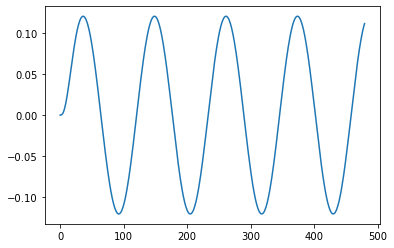

In [160]:
plt.plot(data2[480:])

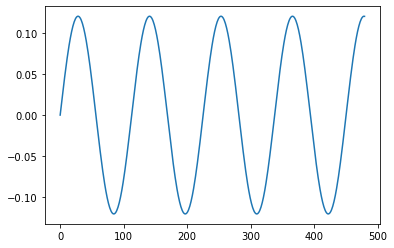

In [158]:
plt.plot(data[480:])

In [144]:
data[470:490]

array([-0.07395831, -0.07630064, -0.07854852, -0.08069919, -0.08274998,
       -0.08469833, -0.08654186, -0.08827827, -0.08990542, -0.09142129,
        0.        ,  0.00353145,  0.00705852,  0.01057686,  0.0140821 ,
        0.01756992,  0.02103599,  0.02447602,  0.02788576,  0.03126098],
      dtype=float32)

In [146]:
data2[480]

0.0

In [ ]:
# THIS WORKS FINE!


# sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
# sock.connect(('localhost', 11586))
# d = sock.recv(12)
# print(d[-4:])

# b = b''
# i = 0

# while True:
#     i += 1
#     size = 8+(441*2*4)#3536#4328#11528#5768#11528 # 480(samps)*2(chans)*12(bytes/samp) + 8 (header)
#     b += sock.recv(size)
#     if len(b) < size:
#         continue
#     b = b[8:] # first 8 is header
    
#     data = np.frombuffer(b, dtype=np.float32)#[:480*2]
#     #data2 = np.ones_like(data, dtype=np.float32)
#     data2 = data*1.1
#     data2 = np.clip(data2, -1, 1)
#     x = torch.tensor(data2)#, device='cuda')
#     #x = F.lowpass_biquad(x.view(-1), 44100, cutoff_freq=800)
#     data2 = x.view(-1).numpy()
#     data2 = np.clip(data2, -1, 1)
#     #x = torch.tensor(data2, device='cuda')
#     #data3 = x.cpu().numpy()
#     #data2 = np.random.random(540*2).astype(np.float32)
#     #data2 = np.ones((540*2, )).astype(np.float32)
#     #data2 = get_samples(400)#random.randint(400,401))[:441*2]#1024]
#     #print(data2.shape)
#     msg2 = data2.tobytes()
#     msg = (15).to_bytes(length=4, byteorder='little')
#     bint = len(msg2)
#     msg += bint.to_bytes(length=4, byteorder='little')
#     msg += msg2
#     #assert len(msg) == size
#     sock.send(msg)
#     b = b'

In [ ]:
b = b''
while True:
    size = 11528 # 480(samps)*2(chans)*12(bytes/samp) + 8 (header)
    b += sock.recv(size)
    if len(b) < size:
        continue
    b = b[8:] # first 8 is header
    data = np.frombuffer(b, dtype=np.float32)
    data2 = data*1.1
    data2 = np.clip(data2, 0.00001, 0.99)
    x = torch.tensor(data2)#, device='cuda')
    #x = F.flanger(x.view(2, 1440), 480)
    x = x.view(2, 1440)
    x = F.band_biquad(x, 48000, 900) #F.flanger(x, 48000, regen=1)
    x = x.view(1, 2880).squeeze(0)
    data3 = x.cpu().numpy()
    #data2 = np.random.random(480)
    #data2 = get_samples(random.randint(400,600))
    msg2 = data3.tobytes()
    msg = (15).to_bytes(length=4, byteorder='little')
    bint = len(msg2)
    msg += bint.to_bytes(length=4, byteorder='little')
    msg += msg2
    sock.send(msg)
    b = b''

In [75]:
import torchaudio.functional as F
import torchaudio.transforms as T

In [121]:
x.shape

torch.Size([2880])

In [147]:
F.flanger(x.view(2, 1440), 480)

tensor([[0.0100, 0.0100, 0.0100,  ..., 0.0100, 0.0100, 0.0100],
        [0.0046, 0.0075, 0.0096,  ..., 0.0100, 0.0100, 0.0100]])

In [148]:
x = F.flanger(x.view(2, 1440), 480)

In [151]:
x.view(1,2880)

tensor([[0.0100, 0.0100, 0.0100,  ..., 0.0100, 0.0100, 0.0100]])

In [181]:
1440/480

3.0